<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Boosting</div>

Boosting is a procedure that combines several "weak" predictors into a powerful "committee". It belongs to the family of committee-based or ensemble methods in Machine Learning.

The most popular Boosting algorithm is AdaBoost.M1 (Freund & Schapire, 1997).

A motivation for Boosting:<br>
*AdaBoost with trees is the best off-the-shelf classifier in the world.* (Breiman 1998)<br>
It is not so true anymore today but still accurate enough in practice.

For recent criticism on that statement, see:<br>
**Random classification noise defeats all convex potential boosters.**<br>
P.H. Long, R.A. Servedio, *Machine Learning*, **78**(3), 287-304, (2008).

In this notebook we take a very practical approach. For a more thorough and rigorous presentation, see (for instance) the reference below.<br>
**The boosting approach to machine learning: An overview.**<br>
R. E. Schapire. *MSRI workshop on Nonlinear Estimation and Classification*, (2002).

1. [Probably Approximately Correct learning](#sec1)
2. [AdaBoost](#sec2)
3. [Implementing AdaBoost with trees](#sec3)
4. [AdaBoost in scikit-learn](#sec4)
5. [Gradient Boosting](#sec5)
6. [Examples](#sec6)
    1. [Spam or Ham?](#sec6-1)
    2. [NIST](#sec6-2)

# 1. Probably Approximately Correct learning

Probably approximately correct (PAC) learning theory helps analyze whether and under what conditions a learning algorithm will probably output an approximately correct classifier.

**"Approximately correct"**. A classifier $h(x)=y$ belonging to some family of fonctions $\mathcal{H}$ and generated by the considered learning algorithm is approximately correct if its error over the distribution $p$ of inputs (its generalization error) is bounded by some $\varepsilon$ (with $0\leq \varepsilon \leq \frac{1}{2}$), that is $\mathbb{E}_{x\sim p} \left( h\left(x\right)\neq\left(x\in c \right) \right) = \int\limits_X I_{h\left(x\right)\neq\left(x\in c\right)} \textrm{d}p(x) \leq \varepsilon$.

**"Probably"**. If, given enough data, the algorithm will output such an approximately correct classifier with probability $1-\delta$ (with $0 \leq \delta \leq \frac{1}{2}$), we call that algorithm *Probably Approximately Correct* (PAC).

In other words, an algorithm generating classifiers $h(x)=y$ is said to be a *Probably Approximately Correct* (PAC) learner (or *PAC-strong* learner) if,<br>
for all $\left\{\begin{array}{l}
p\textrm{ a distribution over } X\\
\varepsilon \in ]0;0.5[\\
\delta \in ]0;0.5[\\
c \in \mathcal{P}(X) \textrm{ a subset of X defining a classification task}
\end{array}\right.$, given enough training data,
$$\mathbb{P}\left(\int\limits_X I_{h\left(x\right)\neq\left(x\in c\right)} \textrm{d}p(x)\leq \varepsilon\right) \geq 1-\delta.$$

Knowing that a target concept $h(x)=y$ is PAC-learnable allows one to lower bound the sample size $m$ necessary to probably learn an approximately correct classifier:
$$m\geq \frac{1}{\varepsilon} \left( \log|\mathcal{H}| + \log\left(\frac{1}{\delta}\right) \right)$$

This lower bound implies that:
- As the precision requirement gets harder (as $\varepsilon$ gets closer to zero) the necessary sample size increases.
- Similarly, if the number of possible classifiers ($|\mathcal{H}|$) increases, the sample size required to disambiguate between two classifiers with good probability increases.
- Finally, as the desired probability of correctness increases (as $\delta$ gets closer to zero), the required sample size increases as well.

Want more details?<br>
**A theory of the learnable.**<br>
L.G. Valiant. *Communications of the ACM*, **27**(11):1134-1142, (1984).<br>
**The strength of weak learnability.**<br>
R.E. Schapire. *Machine Learning*, **5**(2), 197-227, (1990).<br>
[Wikipedia page on sample complexity](https://en.wikipedia.org/wiki/Sample_complexity)

An algorithm generating classifiers $h(x)=y$ is said to be a *weak* (or *PAC-weak*) learner if, for any training set, it performs better than a random guessing on the training data.
This means that its generalization error is strictly below than 0.5 with high probability, formally:
$$\exists \gamma > 0, \mathbb{P}\left(\int\limits_X I_{h\left(x\right)\neq\left(x\in c\right)} \textrm{d}p(x)\leq 0.5 - \gamma \right) \geq 1-\delta.$$
This is almost the same property as PAC-strong, but restricted to the existence of an $\epsilon$ smaller than 0.5 rather than for any value of $\epsilon$.

# <a id="sec2"></a> 2. AdaBoost

AdaBoost constructs a PAC-strong classifier $f$ as a linear combination of weak classifiers $h_t(x)$:
$$f(x) = \sum\limits_{t=1}^T \alpha_t h_t(x)$$

The algorithm:

Given $\left\{\left(x_i,y_i\right)\right\}_{1 \leq i \leq q}, x_i \in X, y_i \in \{-1;1\}$.<br>
Initialize weights $D_1(i) = \frac{1}{q}$<br>
For $t=1$ to $T$:

* Find $h_t = \arg\min\limits_{h\in\mathcal{H}} \sum\limits_{i=1}^q D_t(i) I(y_i\neq h(x_i))$
* If $\epsilon_t = \sum\limits_{i=1}^q D_t(i) I(y_i\neq h_t(x_i)) \geq 1/2$ then stop
* Set $\alpha_t = \frac{1}{2} \log\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$
* Update
$$D_{t+1}(i) = \frac{D_t(i) e^{-\alpha_t y_i h_t(x_i)}}{Z_t}$$
Where $Z_t$ is a normalisation factor.

Return the classifier
$$H(x) = sign\left(\sum\limits_{t=1}^T \alpha_t h_t(x) \right)$$



Consequently, AdaBoost learns a sequence of classifiers, by performing *iterative reweighting* over the training data.

$$D_{t+1}(i) = \frac{D_t(i) e^{-\alpha_t y_i h_t(x_i)}}{Z_t}$$

- Increase the weight of incorrectly classified samples
- Decrease the weight of correctly classified samples
- Memory effect: a sample misclassified several times has a large $D(i)$
- $h_t$ focusses on samples that were misclassified by $h_0, \ldots, h_{t-1}$

Property of the training error:

$$\frac{1}{q} \sum\limits_{i=1}^q I\left(H(x_i)\neq y_i\right) \leq \prod\limits_{t=1}^T Z_t$$

- To minimize training error at each step $t$, minimize this upper bound.<br>
$\rightarrow$ This is where $\alpha_t = \frac{1}{2} \log\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$ comes from.
- This is actually equivalent to maximizing a (geometrical) margin.

Many variants of AdaBoost:
- Binary classification AdaBoost.M1, AdaBoost.M2, ...
- Multiclass AdaBoost.MH,
- Regression AdaBoost.R,

And other Boosting algorithms (BrownBoost, AnyBoost...).

<div class="alert alert-success">
AdaBoost is a meta-algorithm: it "boosts" a weak classification algorithm into a committee that is a strong classifier.
<ul>
<li> AdaBoost maximizes margin
<li> Very simple to implement
<li> Can be seen as a feature selection algorithm
<li> In practice, AdaBoost often avoids overfitting.
</ul>
</div>

# <a id="sec3"></a> 3. Implementing AdaBoost with trees

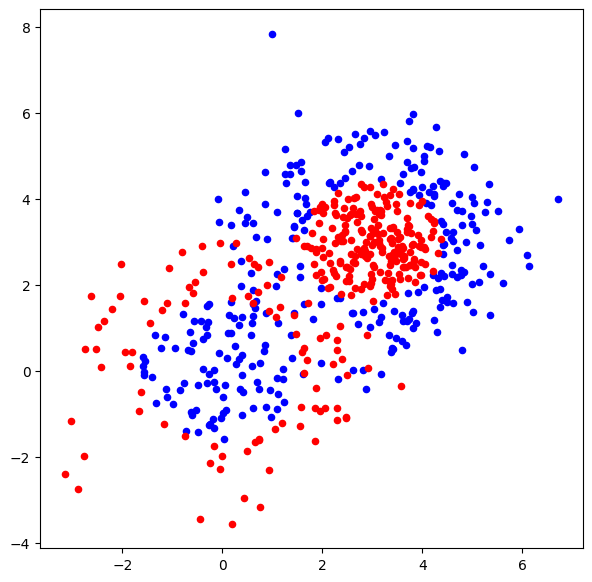

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt

X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure(figsize=(7,7))
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
_=plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)

Let's grow a first tree and display it.

[Text(0.5555555555555556, 0.875, 'x[0] <= 4.236\nentropy = 1.0\nsamples = 600\nvalue = [297, 303]'),
 Text(0.3333333333333333, 0.625, 'x[1] <= 4.363\nentropy = 0.987\nsamples = 531\nvalue = [230, 301]'),
 Text(0.4444444444444444, 0.75, 'True  '),
 Text(0.2222222222222222, 0.375, 'x[1] <= 1.576\nentropy = 0.957\nsamples = 484\nvalue = [183, 301]'),
 Text(0.1111111111111111, 0.125, 'entropy = 0.922\nsamples = 193\nvalue = [128, 65]'),
 Text(0.3333333333333333, 0.125, 'entropy = 0.699\nsamples = 291\nvalue = [55, 236]'),
 Text(0.4444444444444444, 0.375, 'entropy = 0.0\nsamples = 47\nvalue = [47, 0]'),
 Text(0.7777777777777778, 0.625, 'x[0] <= 4.385\nentropy = 0.189\nsamples = 69\nvalue = [67, 2]'),
 Text(0.6666666666666667, 0.75, '  False'),
 Text(0.6666666666666666, 0.375, 'x[0] <= 4.377\nentropy = 0.592\nsamples = 14\nvalue = [12, 2]'),
 Text(0.5555555555555556, 0.125, 'entropy = 0.391\nsamples = 13\nvalue = [12, 1]'),
 Text(0.7777777777777778, 0.125, 'entropy = 0.0\nsamples = 1\nvalue 

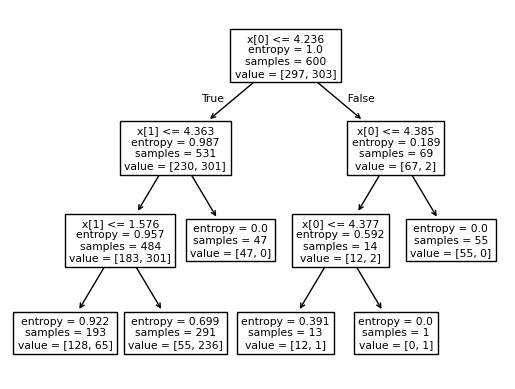

In [2]:
from sklearn import tree
from os import system
from IPython.display import Image

dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
dt1.fit(X,y)


tree.plot_tree(dt1)

We would like to plot the tree's decision boundary. Let's take this occasion to plot the misclassified training points (in cyan and magenta).

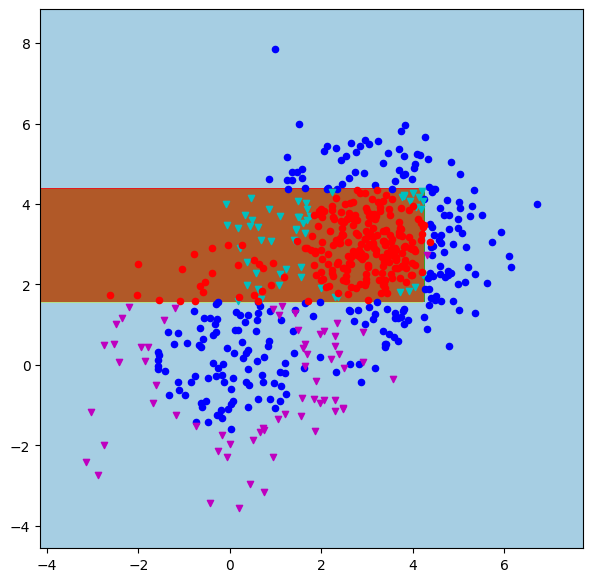

Training error: 0.201667
Testing error:  0.2125


In [3]:
def plot_decision_boundary(t, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = t.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = t.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

plot_decision_boundary(dt1, X, y)
print("Training error: %g"%(1-dt1.score(X,y)))
print("Testing error:  %g"%(1-dt1.score(Xtest,ytest)))

To implement our AdaBoost algorithm, we will need a function that evaluates the majority vote of a given set of trees (a forest) and another function that plots the forest's decision boundary.

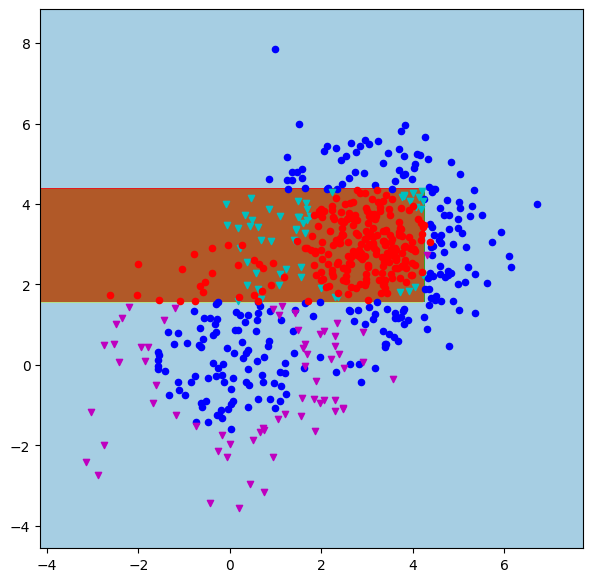

In [4]:
def forest_predict(f, weights, X):
    N = len(f)
    votes = np.zeros((X.shape[0],N))
    for i in range(N):
        votes[:,i] = weights[i]*f[i].predict(X)
    pred = np.sum(votes,axis=1)
    return np.sign(pred)

def plot_decision_boundary_forest(f, weights, X, y, fig_size=(7,7)):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = forest_predict(f, weights, np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure(figsize=fig_size)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = forest_predict(f, weights, X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b',s=20)
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v',s=20)
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r',s=20)
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v',s=20)
    plt.show()

forest = [dt1]
plot_decision_boundary_forest(forest,np.ones(1),X,y)

Now we can implement an AdaBoost algorithm with trees and visualize its decision boundary.<br>
<div class="alert alert-warning">
    
**Exercice**:<br>
Using the elements introduced above, implement AdaBoost on a forest containing 100 trees, trained on the current dataset.<br>
Display how the decision boundary evolves.<br>
Plot on the same graph the evolution of the training and testing errors.
</div>

In [ ]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


<div class="alert alert-warning">
    
**Question**:
Is there a tendency to overfit?
</div>

# <a id="sec4"></a> 4. AdaBoost in scikit-learn

Scikit-learn provides an [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) meta-algorithm.

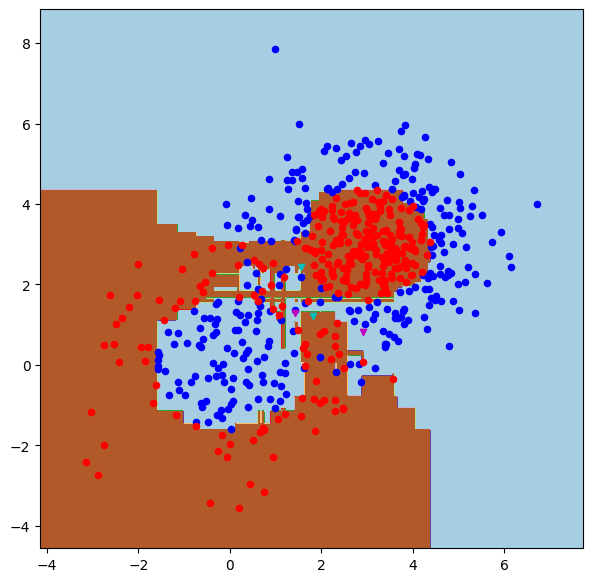

Training score: 0.9933333333333333
Testing score:  0.92


In [5]:
from sklearn.ensemble import AdaBoostClassifier

boosted_forest = AdaBoostClassifier(tree.DecisionTreeClassifier(criterion='entropy',max_depth=3), n_estimators=100)
boosted_forest.fit(X,y)

plot_decision_boundary(boosted_forest,X,y)
print("Training score:", boosted_forest.score(X,y))
print("Testing score: ", boosted_forest.score(Xtest,ytest))

# <a id="sec5"></a> 5. Gradient Boosting

AdaBoost incrementally builds a committee of classifiers (or regressors) where each one tries to compensate the weaknesses of all the previous ones. This description makes it sound a lot like gradient descent.

Let's write $f_k = \{h_0,\ldots,h_k\}$ the committee predictor obtained at step $k$. $f_k$ is a point in $\mathcal{H}$ and our goal is to find the function (the point) in $\mathcal{H}$ that minimizes a certain loss function $L(f), \ f\in\mathcal{H}$. Therefore, $h_{k+1}$ should point in the opposite direction of the gradient of $L$ with respect to functions $f$.

This is precisely the idea of Gradient Boosting, that extends traditionnal Boosting to any differentiable loss function. Let's write this formally.

Suppose we have a loss function $L(f(x),y)$ that quantifies how bad a predictor $f$ is, given the true data pair $(x,y)$. This could be a squared error, a cross-entropy, or any other loss function that compares $f(x)$ to the true $(x,y)$ data.

Our goal is to find $f_{k+1}$ so that it compensates the error of $f_k$ made at each input $x$. In other words, we would like to move the output of the predictor $f_k$ so that the loss reduces at each $x$. Thus, we will look at the variation of the loss with respect to the variation of the prediction of $f_k$. Formally, this is the derivative of the loss $L(f_k(x), y)$ with respect to the prediction $f_k(x)$.
$$\frac{\partial L(f_k(x), y)}{\partial f_k(x)}$$

As in gradient descent, by adding the new weak learner $h_k$, we would like to move in the opposite direction (steepest descent reducing the loss) from a certain quantity $\alpha_k$:
$$f_{k+1} = f_{k} - \alpha_{k} h_{k}$$

Practically, we do not have an estimate of $\frac{\partial L(f_k(x), y)}{\partial f_k(x)}$ for any $x$, but only on the data set $\{(x_i, y_i)\}_i$. This yields the following desired value of $h_{k}$ for all $(x_i, y_i)$: $\frac{\partial L(f_k(x_i), y_i)}{\partial f_k(x_i)}$.
Thus, we will seek to fit $h_k$ to the following training set:
$$\left\{ \left(x_i, \frac{\partial L(f(x_i), y_i)}{\partial f(x_i)} \right) \right\}_i$$

This result is the essence of the gradient boosting method. The latter training set can be seen as the set of points that compensates the error (or reduces the loss) of $f_k$ at each $x_i$.

Notice that for gradient boosting to be applied, the only requirement is for the loss function to be differentiable. The weak learners themselves could be any functions.



The algorithm can be written as follows:

$f_0 = \arg\min_\gamma \sum_i L(\gamma, y_i)$<br>
For $k=1$ to $K$
* Compute the pseudo-residuals
$$r_i = \left[ \frac{\partial L(f(x_i), y)}{\partial f(x_i)} \right]_{f = f_{k-1}}$$
* Train $h_k$ to fit the dataset $\left(x_i, r_i\right)$
* Find $\alpha_k$ though line search
$$\alpha_{k} = \arg\min_\alpha \left[ \sum_i L\left(f_{k-1}(x_i) + \alpha h_{k}(x_i),y_i\right) \right]$$
* Update the model
$$f_k = f_{k-1} + \alpha_k h_k$$
Return $f_K$


AdaBoost is actually a Gradient Boosting procedure.

When $\mathcal{H}$ is the set of regression or classification trees, Gradient Boosting is called **Gradient Tree Boosting**. Several extensions (regularization, local step-sizes, etc.) are possible in that case.

The most well-known Gradient Boosting library is called [XGBoost](https://github.com/dmlc/xgboost). It is efficient and quite flexible. It has be used to win several Data Science competitions. But Scikit-Learn also provides a decent implementation that we will use below.

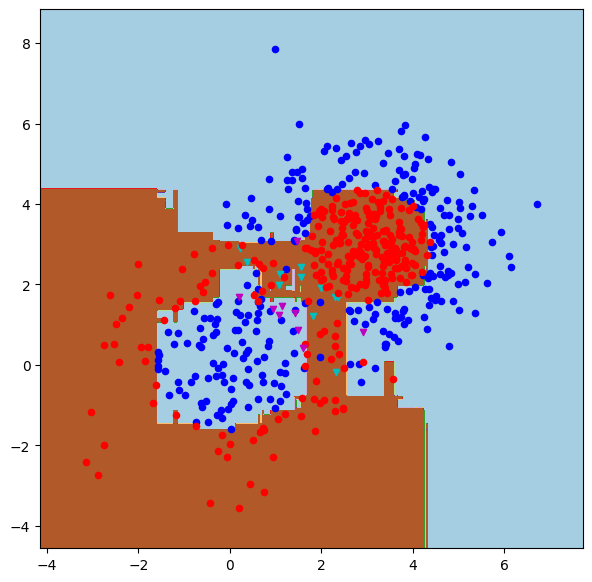

Training score: 0.9666666666666667
Testing score:  0.895


In [6]:
from sklearn.ensemble import GradientBoostingClassifier

gtb = GradientBoostingClassifier(n_estimators=100)
gtb.fit(X,y)

plot_decision_boundary(gtb,X,y)
print("Training score:", gtb.score(X,y))
print("Testing score: ", gtb.score(Xtest,ytest))

Forward stagewise boosting (Algorithm 10.2) is also a very greedy strategy.
At each step the solution tree is the one that maximally reduces (10.29)# <a id="sec6"></a> 6. Examples

If you have done the previous notebooks, you are used to these two examples now.

## <a id="sec6-1"></a>6.1 Spam or ham?

In [7]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

/home/mohamed/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
spam_ada = AdaBoostClassifier(tree.DecisionTreeClassifier(criterion='entropy',max_depth=3), n_estimators=100)
spam_ada.fit(Xtrain,ytrain)
print("score:", spam_ada.score(Xtest,ytest))

score: 0.973124300111982


In [9]:
spam_gtb = GradientBoostingClassifier(n_estimators=100)
spam_gtb.fit(Xtrain,ytrain)
print("score:", spam_gtb.score(Xtest,ytest))

score: 0.9641657334826428


In [11]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')

In [12]:
spam_ada = AdaBoostClassifier(tree.DecisionTreeClassifier(criterion='entropy',max_depth=3), n_estimators=100)
spam_ada.fit(Xtrain,ytrain)
print("score:", spam_ada.score(Xtest,ytest))

score: 0.9764837625979843


In [13]:
spam_gtb = GradientBoostingClassifier(n_estimators=100)
spam_gtb.fit(Xtrain,ytrain)
print("score:", spam_gtb.score(Xtest,ytest))

score: 0.9652855543113102


## <a id="sec6-2"></a> 6.2 NIST

In [16]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])

#print(digits.DESCR)

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [17]:
from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [18]:
print(Xtrain.shape)
print(ytrain.shape)
digits_ada = AdaBoostClassifier(tree.DecisionTreeClassifier(criterion='entropy',max_depth=3), n_estimators=100)
digits_ada.fit(Xtrain,ytrain)
prediction = digits_ada.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_ada.score(Xtest,ytest))

(1000, 64)
(1000,)
Generalization error: 0.11292346298619825
Generalization score: 0.8870765370138017


In [19]:
digits_gtb = GradientBoostingClassifier(n_estimators=100)
digits_gtb.fit(Xtrain,ytrain)
prediction = digits_ada.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_gtb.score(Xtest,ytest))

Generalization error: 0.11292346298619825
Generalization score: 0.9021329987452948


# <a id="sec6"></a> 6.3 Further Examples

**Questions** :
- Choose one of the dataset that you have used in a previous notebook - with a binary classification task. Compare both algorithm performances on this dataset.
- Identify which parameter acts as a discrimination threshold on each algorithm and compare both of them using a ROC curve.